#Вопрос 1
В этом задании вам предлагается проанализировать данные одной из американских телекоммуникационных компаний о пользователях, которые потенциально могут уйти.

churn_analysis.csv
Измерены следующие признаки:

state — штат США
account_length — длительность использования аккаунта
area_code — деление пользователей на псевдорегионы, использующееся в телекоме
intl_plan — подключена ли у пользователя услуга международного общения
vmail_plan — подключена ли у пользователя услуга голосовых сообщений
vmail_message — количество голосых сообщений, который пользователь отправил / принял
day_calls — сколько пользователь совершил дневных звонков
day_mins — сколько пользователь проговорил минут в течение дня
day_charge — сколько пользователь заплатил за свою дневную активность
eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
custserv_calls — сколько раз пользователь позвонил в службу поддержки
treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)
mes_estim — оценка интенсивности пользования интернет мессенджерами
churn — результат оттока: перестал ли абонент пользоваться услугами оператора
Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

Для этого мы воспользуемся критерием хи-квадрат. Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn. Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции

scipy.stats.chi2_contingency(subtable, correction=False)

Заметьте, что, например, (AZ, HI) и (HI, AZ) — это одна и та же пара. Обязательно выставьте correction=False (о том, что это значит, вы узнаете из следующих вопросов).

Сколько достигаемых уровней значимости оказались меньше, чем α=0.05?

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import itertools

data = pd.read_csv('Week4/churn_analysis.csv', sep=',')
states_combin = itertools.combinations(data.state.unique(), 2)
states_chi2 = pd.DataFrame(np.empty(0, 
                                    dtype=[('st0', 'S20'), ('st1', 'S20'),('p_chi2', 'f8')]))

for st in states_combin:
    st0f=len(data[(data['state']==st[0])& (data['churn']=='False.')&(data['treatment']==1)])
    st0t=len(data[(data['state']==st[0])& (data['churn']=='True.')&(data['treatment']==1)])
    st1f=len(data[(data['state']==st[1])& (data['churn']=='False.')&(data['treatment']==1)])
    st1t=len(data[(data['state']==st[1])& (data['churn']=='True.')&(data['treatment']==1)])
    chi2=stats.chi2_contingency([[st0f,st0t],[st1f,st1t]], correction=False)
    #row=pd.DataFrame([st[0], st[1], chi2[1]], columns=['st0','st1','p_chi2'])
    #np.append(states_chi2,row, axis=0)
    states_chi2 = states_chi2.append({'st0': st[0],'st1': st[1],'p_chi2': chi2[1]}, ignore_index=True)

In [65]:
len(states_chi2[states_chi2['p_chi2']<0.05])

34

#Вопрос 2
Какие проблемы Вы видите в построении анализа из первого вопроса? Отметьте все верные утверждения.

__Применение критерия xи-квадрат для этих данных не обосновано, потому что не выполняются условия, при которых этот критерий дает правильные результаты.__

Поправку на множественную проверку здесь применять нельзя — она используется только для группы критериев, проверяющих равенство средних (типа t-критерия). Критерий xи-квадрат не принадлежит этому семейству, поэтому поправка не нужна.

Хи-квадрат используется для того, чтобы сравнить выборку с некоторым воздействием (treatment) и выборку без этого воздействия (control). Мы же в первом задании сравнивали штаты, используя данные только control группы. Для данных только из control группы использование xи-квадрат неправомерно.

__Интерпретация числа достигаемых уровней значимости, меньших α=0.05, некорректна, поскольку не сделана поправка на множественную проверку гипотез.__

Анализ нужно было начинать с применения xи-квадрат к таблице сопряженности, в которой присутствовали сразу все возможные штаты. Достигаемой уровень значимости такой проверки = 0.7, что дает нам гарантию, что нет ни одной пары штатов, в которых отличие в соотношениях ушедших и оставшихся клиентов статистически значимо.

#Вопрос 3
В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в таблице сопряженности может быть аппроксимировано с помощью непрерывного распределения xи-квадрат. Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность. Эта поправка заключается в вычитании константы 0.5 из каждого модуля разности наблюденного Oi и ожидаемого Ei значений, то есть, статистика с такой поправкой выглядит так:
χ2Yates=∑i=1N(|Oi−Ei|−0.5)2Ei.
Такая поправка, как несложно догадаться по формуле, как правило, уменьшает значение статистики χ2, то есть увеличивает достигаемый уровень значимости.

Эта поправка обычно используется для таблиц сопряженности размером 2x2 и для небольшого количества наблюдений. Такая поправка, однако, не является серебрянной пулей, и часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода).

Полезно знать, что эта поправка часто включена по умолчанию (например, в функции scipy.stats.chi2_contingency) и понимать ее влияние на оценку достигаемого уровня значимости.

Проведите те же самые сравнения, что и в вопросе №1, только с включенной коррекцией


scipy.stats.chi2_contingency(subtable, correction=True)
и сравните полученные результаты, отметив все верные варианты.

__Количество достигаемых уровней значимости, меньших, чем 0.05, в точности равно нулю. То есть поправка увеличила достигаемые уровни значимости настолько, что больше ни одно из значений достигаемого уровня значимости не попадает в диапазон от 0 до 0.05.__

Поправка Йетса на непрерывность всегда увеличивает значение достигаемого уровня значимости, поэтому все получившиеся значения достигаемого уровня значимости строго больше или равны таковым значениям при отсутствии этой поправки.

Количество достигаемых уровней значимости, меньших, чем 0.05, почти не изменилось, нельзя сказать, что введенная поправка сильно поменяла достигаемые уровни значимости.

__Достигаемые уровни значимости на наших данных, полученные с помощью критерия xи-квадрат с поправкой Йетса, в среднем получаются больше, чем соответствующие значения без поправки.__

In [87]:
states_combin = itertools.combinations(data.state.unique(), 2)
states_chi2_t = pd.DataFrame(np.empty(0, 
                                    dtype=[('st0', 'S20'), ('st1', 'S20'),('p_chi2', 'f8')]))

for st in states_combin:
    
    st0f=len(data[(data['state']==st[0])& (data['churn']=='False.')&(data['treatment']==1)])
    st0t=len(data[(data['state']==st[0])& (data['churn']=='True.')&(data['treatment']==1)])
    st1f=len(data[(data['state']==st[1])& (data['churn']=='False.')&(data['treatment']==1)])
    st1t=len(data[(data['state']==st[1])& (data['churn']=='True.')&(data['treatment']==1)])
    chi2=stats.chi2_contingency([[st0f,st0t],[st1f,st1t]], correction=True)
    states_chi2_t = states_chi2_t.append({'st0': st[0],'st1': st[1],'p_chi2': chi2[1]}, ignore_index=True)

In [81]:
states_chi2_t[states_chi2_t['p_chi2']<0.05]

,st0,st1,p_chi2


#Вопрос 4
Что если у нас мало данных, мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку, предположения критерия xи-квадрат не выполняются, а проверить гипотезу о том, что данные принадлежат одному распределению, нужно ?

В таком случае прибегают к так называемому точному критерию Фишера. Этот критерий не использует приближений и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.

Пусть у нас есть таблица сопряженности 2x2:

Группа 1	Группа 2	Σ
Воздействие 1	a	b	a+b
Воздействие 2	c	d	c+d
Σ	a+c	b+d	n=a+b+c+d
Тогда вероятность получить именно такие a,b,c,d при фиксированных значениях сумм по строкам и по столбцам) задается выражением

p=(a+ba)(c+dc)(na+c)=(a+b)! (c+d)! (a+c)! (b+d)!/a!  b!  c!  d!  n!.
В числителе этой дроби стоит суммарное количество способов выбрать a и c из a+b и c+d соответственно. А в знаменателе — количество способов выбрать число объектов, равное сумме элементов первого столбца a+c из общего количества рассматриваемых объектов n.

Чтобы посчитать достигаемый уровень значимости критерия Фишера, нужно перебрать все возможные значения a,b,c,d, в клетках этой таблицы так, чтобы построковые и постолбцовые суммы не изменились. Для каждого такого набора a,b,c,d нужно вычислить значение pi по формуле выше и просуммировать все такие значения pi, которые меньше или равны p, которое мы вычислили по наблюдаемым значениям a,b,c,d.

Понятно, что такой критерий вычислительно неудобен в силу большого количества факториалов в формуле выше. То есть даже при небольших выборках для вычисления значения этого критерия приходится оперировать очень большими числами. Поэтому данным критерием пользуются обычно только для таблиц 2x2, но сам критерий никак не ограничен количеством строк и столбцов, и его можно построить для любой таблицы n×m.

Посчитайте для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами, описанными выше.

Точный критерий Фишера удобно вычислять с помощью функции



1
scipy.stats.fisher_exact
которая принимает на вход таблицу сопряженности 2x2.

Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем большие, чем xи-квадрат с поправкой Йетса

Точный критерий Фишера точно также, как и критерий xи-квадрат, нельзя использовать, если наблюдений < 40 и если ожидаемое значение меньше 5 больше чем в 20% ячейках.

__Точный критерий Фишера всегда лучше, чем критерий xи-квадрат, потому что не использует аппроксимацию дискретного распределения непрерывным. Однако при увеличении размера выборки его преимущества по сравнению с критерем xи-квадрат уменьшаются, в пределе достигая нуля.__

__Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем значительно большие, чем xи-квадрат без поправки__

Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат без поправки

__Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат с поправкой Йетса__

In [85]:
states_combin = itertools.combinations(data.state.unique(), 2)
states_fisher = pd.DataFrame(np.empty(0, 
                                    dtype=[('st0', 'S20'), ('st1', 'S20'),('p', 'f8')]))

for st in states_combin:
    st0f=len(data[(data['state']==st[0])& (data['churn']=='False.')&(data['treatment']==1)])
    st0t=len(data[(data['state']==st[0])& (data['churn']=='True.')&(data['treatment']==1)])
    st1f=len(data[(data['state']==st[1])& (data['churn']=='False.')&(data['treatment']==1)])
    st1t=len(data[(data['state']==st[1])& (data['churn']=='True.')&(data['treatment']==1)])
    odds, pvalue=stats.fisher_exact([[st0f,st0t],[st1f,st1t]])
    states_fisher = states_fisher.append({'st0': st[0],'st1': st[1],'p': pvalue}, ignore_index=True)

In [91]:
print 'Fisher- %f' % (states_fisher['p'].mean())
print 'Chi2- %f' % (states_chi2['p_chi2'].mean())
print 'Chi2+correct - %f' % (states_chi2_t['p_chi2'].mean())

Fisher- 0.648338
Chi2- 0.501827
Chi2+correct - 0.664057


#Вопрос 5
Давайте попробуем применить полученные знания о разных видах корреляции и ее применимости на практике.

Рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость.

Отметьте все верные утверждения.

Корреляция Пирсона имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 не значимо.

Все варианты неверны, потому что значимость корреляции Пирсона можно оценивать только для нормального распределения, как и упоминалось в лекциях.

Корреляция Пирсона имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.

__Корреляция Пирсона имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.__

Корреляция Пирсона имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 не значимо.

Populating the interactive namespace from numpy and matplotlib


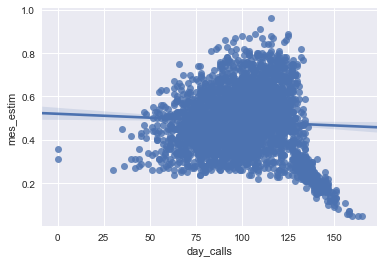

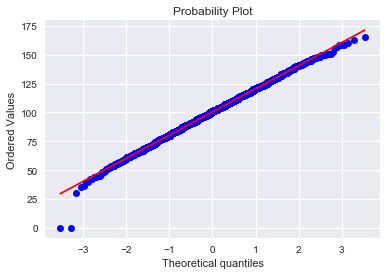

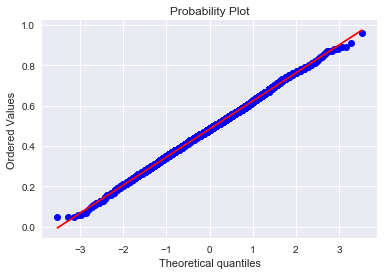

-0.0517943505876
0.00277988368698


In [12]:
import seaborn
import matplotlib.pyplot as plt
%pylab inline
seaborn.regplot(x='day_calls', y='mes_estim', data=data); plt.show()
stats.probplot(data['day_calls'], dist="norm", plot=pylab)
pylab.show()
stats.probplot(data['mes_estim'], dist="norm", plot=pylab)
pylab.show()
corr, p = stats.pearsonr(data['day_calls'], data['mes_estim'])
print corr
print p

#Вопрос 6
Еще раз рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Спирмена между этими признаками на всех данных, ее значимость.

Отметьте все верные утверждения.

Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 не значимо.

__Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.__

Корреляция Спирмена тут неприменима, поскольку речь идет о непрерывных величинах, а корреляция Спирмена применяется к выборочным рангам двух выборок.

Корреляция Спирмена имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.

Корреляция Спирмена имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 не значимо.

In [6]:
corr, p = stats.spearmanr(data['day_calls'], data['mes_estim'])
print corr
print p

0.0433498805339
0.0123173671892


#Вопрос 7
Как можно интерпретировать полученные значения коэффициентов корреляции и достигаемые уровни значимости при проверки гипотез о равенстве нулю этих коэффициентов?

Не стоит ориентироваться на значение корреляции Спирмена, потому что корреляцию Спирмена можно считать только тогда, когда оба признака дискретные и между значениями можно установить строгий порядок.

Предположение нормальности данных двух признаков не выполнено, что хорошо видно на ку-ку графике, поэтому корреляция Пирсона может быть полностью неадекватна.

__Посчитанные корреляции и их значимости говорят лишь о том, что необходимо взглянуть на данные глазами и попытаться понять, что приводит к таким (противоречивым?) результатам.__

Подсчет корреляций не имеет особого смысла, поскольку корреляция ничего не говорит о том, какая на самом деле зависимость имеется между признаками.

#Вопрос 8
Посчитайте значение коэффицента корреляции Крамера между двумя признаками: штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1). Что можно сказать о достигаемом уровне значимости при проверке гипотезы о равенство нулю этого коэффициента?

Достигаемый уровень значимости < 0.05, то есть, отличие от нуля значения коэффицента Крамера значимо.

Достигаемый уровень значимости > 0.05, то есть, отличие от нуля значения коэффицента Крамера незначимо.

__Для вычисления коэффициента Крамера используется значение статистики xи-квадрат, на которую мы не можем положиться применительно к нашим данным.__

Коэффициент корреляции Крамера не может быть использован для сравнения связи этих двух признаков, потому что он используется для таблиц сопряженности, где каждая из размерностей больше двух. Если хотя бы одна из размерностей равна 2, то нужно использовать коэффициент корреляции Мэтьюса.

#Вопрос 9
Вы прослушали большой курс и к текущему моменту обладете достаточными знаниями, чтобы попытаться самостоятельно выбрать нужный метод / инструмент / статистический критерий и сделать правильное заключение.

В этой части задания вам нужно будет самостоятельно решить, с помощью каких методов можно провести анализ эффективности удержания (churn) с помощью раличных методов (treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1).

Что можно сказать об этих двух методах (treatment = 0, treatment = 2)? Одинаковы ли они с точки зрения эффективности? Каким бы методом вы бы посоветовали воспользоваться компании?

Не забудьте про поправку на множественную проверку! И не пользуйтесь односторонними альтернативами, поскольку вы не знаете, к каким действительно последствиям приводят тестируемые методы (treatment = 0, treatment = 2) !

Ни один из методов не показал значительного улучшения относительно других, о чем говорит групповой статистический критерий.

treatment = 0 статистически значимо отличается от контрольной группы treatment = 1

treatment = 2 статистически значимо отличается от контрольной группы treatment = 1

В дальнейшем телеком компании рекомендуется использовать и treatment = 0, и treatment = 2 для наибольшей эффективности удержения абонентов.

Отличие между treatment = 0 и treatment = 2 относительно влияния на уровень churn статистически незначимо.

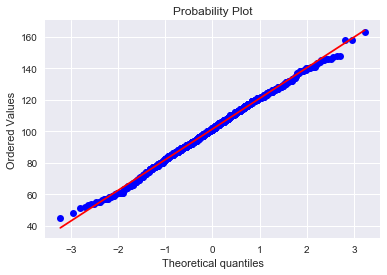

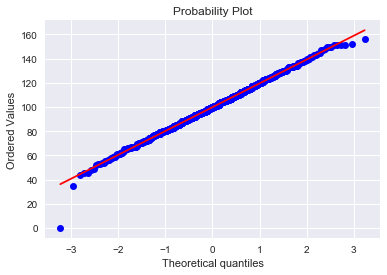

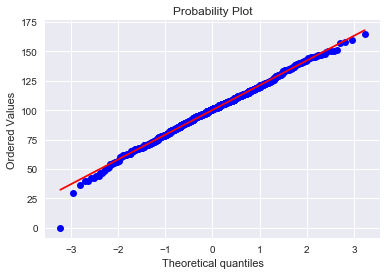

In [16]:
#Проверяем нормальность выборок, чтобы определить параметрические или непараметрические критерии использовать.
stats.probplot(data['day_calls'][data['treatment']==1], dist="norm", plot=pylab)
pylab.show()
stats.probplot(data['day_calls'][data['treatment']==0], dist="norm", plot=pylab)
pylab.show()
stats.probplot(data['day_calls'][data['treatment']==2], dist="norm", plot=pylab)
pylab.show()

In [ ]:
#Графики показывают нормальность - 
# можем использовать параетрические критерии с поправкой на множественность гипотез